In [12]:
#autoreload
%load_ext autoreload
%autoreload 2

import torch
from torchmetrics import AUROC
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import os

import sys
sys.path.append("../../src_clasificacion_vistas/common")

import pycimg

from pathlib import Path
import cv2
from tqdm import tqdm
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
np.set_printoptions(precision=3, suppress=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def crearMosaico(imagenes):
    """
    Crea un mosaico a partir de una lista de imágenes.
    """

    #Convertir las imágenes de tensores c x h x w float32 entre 0 y 1 a uint8 entre 0 y 255 h x w x c
    for i in range(len(imagenes)):
        imagenes[i] = (imagenes[i].permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    
    # Obtener el tamaño de la imagen
    alto, ancho = imagenes[0].shape[:2]
    
    # Redimensionar todas las imágenes al tamaño de la primera
    # imagenes[0] = cv2.cvtColor(imagenes[0], cv2.COLOR_BGR2RGB)
    for i in range(1, len(imagenes)):
        imagenes[i] = cv2.resize(imagenes[i], (ancho, alto))
    #     imagenes[i] = cv2.cvtColor(imagenes[i], cv2.COLOR_BGR2RGB)

    # Calcular el número de filas y columnas
    num_imagenes = len(imagenes)
    num_columnas = int(np.ceil(np.sqrt(num_imagenes)))
    num_filas = int(np.ceil(num_imagenes / num_columnas))
    #print(f"num_imagenes: {num_imagenes}, num_columnas: {num_columnas}, num_filas: {num_filas}")

    # Crear una imagen en blanco para el mosaico
    mosaico = np.zeros((alto * num_filas, ancho * num_columnas, 3), dtype=np.uint8)

    # Colocar las imágenes en el mosaico
    for i, img in enumerate(imagenes):
        fila = i // num_columnas
        columna = i % num_columnas
        mosaico[fila * alto:(fila + 1) * alto, columna * ancho:(columna + 1) * ancho] = img

    return mosaico

In [ ]:
current_file_dir = os.getcwd()
train_results_json="../out_evaluate_patch_repasoD/train_scores.json"
val_results_json="../out_evaluate_patch_repasoD/val_scores.json"
test_results_json="../out_evaluate_patch_repasoD/test_scores.json"

train_results_json=os.path.join(current_file_dir,train_results_json)  
val_results_json=os.path.join(current_file_dir,val_results_json)    
test_results_json=os.path.join(current_file_dir,test_results_json)    

out_dir="/home/aalbiol/Desktop/repasoE"

Path(out_dir).mkdir(parents=True, exist_ok=True)



def create_gold_master_pdf(data,clases,pdfname):

    with PdfPages(pdfname) as pdf:
        fig, axes=plt.subplots(1,2,figsize=(10,5),gridspec_kw={'width_ratios': [1, 2]})
        for d in tqdm(data):

            filenamenpz=d['filename']
            filenamejson=filenamenpz.replace(".npz",".json")
            filenamepng=filenamenpz.replace(".npz",".png")
            
            scores=d['scores']
            ground_truth=d['ground_truth']
            gts=[v for k,v in ground_truth.items() if k in clases]
            preds=[v for k,v in scores.items() if k in clases]
            defectoss=[k for k,v in scores.items() if k in clases]
            
            kk=os.path.join("..",filenamejson)
            npzfilename=kk.replace(".json",".npz")


            imagenes=pycimg.npzread_torch(npzfilename,kk,channel_list=['R','G','B'])
            mosaico=crearMosaico(imagenes)
        #Generar imágenes de los errores

                    
            bn=os.path.basename(filenamejson)
            bn=bn.replace(".json","")        
            #fig, axes=plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 2]})

            axes[0].bar(defectoss,gts)
            axes[0].bar(defectoss,preds)

            axes[0].tick_params(axis='x',rotation=90)
            axes[0].set_ylim([0,1])
            axes[0].set_yticks(np.arange(0, 1.1, 0.1))
            axes[0].grid()



            axes[1].imshow(mosaico)
            axes[1].axis('off')
            axes[1].set_title(f'{bn}')
            
            pdf.savefig(fig, bbox_inches='tight', dpi=300)
            
            axes[0].clear()
            axes[1].clear()        

        fig.close()

In [10]:
## Leer los archivos

with open(train_results_json, "r") as f:
    train_dict = json.load(f)

with open(val_results_json, "r") as f:
    val_dict = json.load(f)  

with open(test_results_json, "r") as f:
    test_dict = json.load(f)    


train_data=train_dict['train_results']
val_data = val_dict['val_results']
test_data = test_dict['test_results']

clases=list(train_dict['train_results'][0]['ground_truth'].keys())

all_data=train_data+val_data

print(len(train_data))
print(len(val_data))
print(len(test_data))
print(len(all_data))

1138
326
162
1464


100%|██████████| 162/162 [00:27<00:00,  5.94it/s]


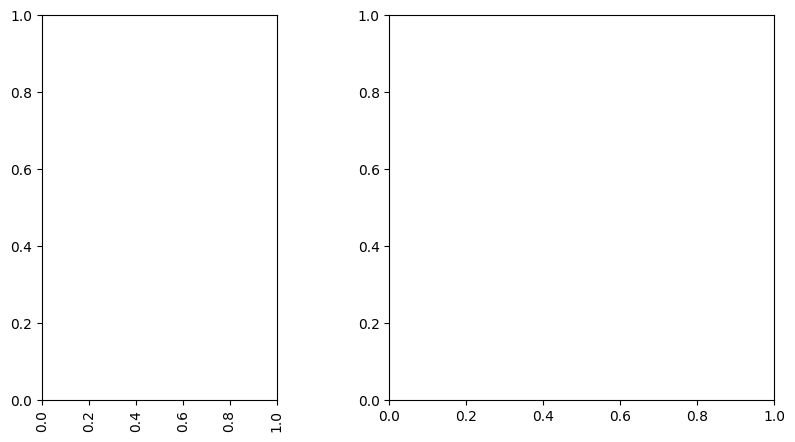

In [13]:
Path(out_dir).mkdir(parents=True, exist_ok=True)
pdfname=os.path.join(out_dir,"gold_master.pdf")
create_gold_master_pdf(test_data,clases,pdfname)